In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing, model_selection, neighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(rc = {"figure.figsize":(10, 6)}) #graph size

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df = pd.read_csv("card_transdata.csv")

In [ ]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [ ]:
df.shape

(1000000, 8)

In [ ]:
df.describe().style.background_gradient(cmap = "plasma")

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


**Correlation Heatmap**

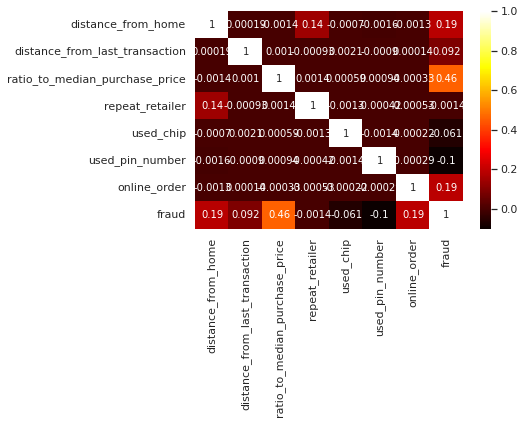

In [ ]:
corr = df.corr()

sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = "hot")

fraud
0.0    912597
1.0     87403
dtype: int64

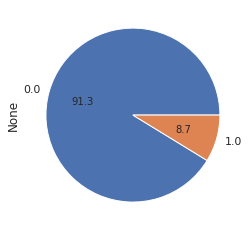

In [ ]:
# Class distribution
# Real (class 0.0) meaning non-fraudulent transactions
# Fraud (class 1.0) meaning fraudulent transactions
df.value_counts("fraud").plot.pie(autopct = "%.1f")
df.value_counts("fraud")

**Under-sampling (Down Sampling)**

In [ ]:
real = df[df["fraud"] == 0]
fraud = df[df["fraud"] == 1]

# Resampling the original dataset with 87,403 datapoints for both classes
real_resample = real.sample(n = 87403, random_state = 123)
fraud_resample = fraud.sample(n = 87403, random_state = 123)

# Creating new dataset consisting of equal class occurence
df0 = pd.concat([real_resample, fraud_resample], axis = 0)

fraud
0.0    87403
1.0    87403
dtype: int64

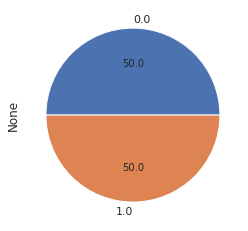

In [ ]:
df0.value_counts("fraud").plot.pie(autopct = "%.1f")
df0.value_counts("fraud")

In [ ]:
X = np.array(df0.drop(columns = "fraud"))
y = np.array(df0["fraud"])

In [ ]:
X

array([[ 5.14636996,  0.58182653,  2.02016344, ...,  0.        ,
         0.        ,  1.        ],
       [ 7.01422837,  4.09857178,  0.09027432, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.48897996,  1.91892066,  0.70384718, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.73442111,  0.91137296, 10.00984897, ...,  0.        ,
         0.        ,  0.        ],
       [12.71459858,  1.56958598,  5.98871079, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.81409159,  2.55411223,  4.77168618, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
# Creating Train Test Split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 123, shuffle = True)

In [ ]:
type(y_test)

numpy.ndarray

In [ ]:
print(y_test)

[0. 1. 1. ... 0. 0. 1.]


In [ ]:
np.shape(y_test)

(34962,)

In [ ]:
# Data scaling to produce good results
scale = MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
model = LogisticRegression(solver='liblinear', random_state=0, max_iter=200).fit(X_train, y_train)

In [ ]:
model.classes_

array([0., 1.])

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

array([0., 1., 1., ..., 0., 0., 1.])

In [ ]:
np.shape(y_pred)

(34962,)

In [ ]:
confusion_matrix(y_test, y_pred)

array([[15832,  1670],
       [ 1227, 16233]])

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92     17502
         1.0       0.91      0.93      0.92     17460

    accuracy                           0.92     34962
   macro avg       0.92      0.92      0.92     34962
weighted avg       0.92      0.92      0.92     34962



**K Nearest Neighbors Classifier**

In [ ]:
# Empty lists for appending each value of k
train_accuracy = []
test_accuracy = []

In [ ]:
# Iterate through values of k and store results
for k in range(3, 16):
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    train_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_test, y_test))

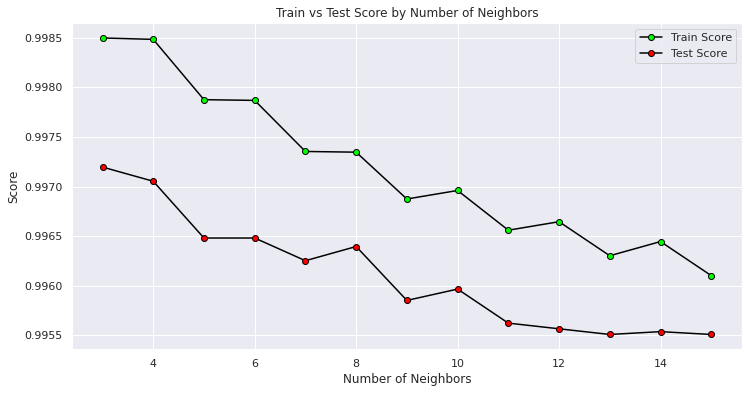

In [ ]:
# Displaying model accuracy for different values of k
plt.figure(figsize = (12, 6))

plt.plot(range(3, 16), train_accuracy, label = "Train Score",
         marker = "o", markerfacecolor = "#00FF00", color = "#000000")

plt.plot(range(3, 16), test_accuracy, label = "Test Score",
         marker = "o", markerfacecolor = "#FF0000", color = "#000000")

plt.xlabel("Number of Neighbors")
plt.ylabel("Score")
plt.title("Train vs Test Score by Number of Neighbors")
plt.legend()
plt.show()

**The accuracy of our KNN model decreases as the value of k increases. Let's use k = 3 for best performance.**

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[17417,    85],
       [   13, 17447]])

In [ ]:
precision_score(y_test, y_pred)

0.9951517225644536

Text(84.5, 0.5, 'Truth')

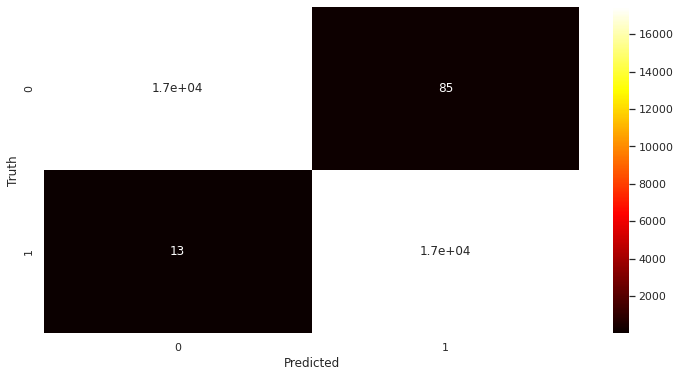

In [ ]:
plt.figure(figsize = (12, 6))

sns.heatmap(cm, annot = True, cmap = "hot")
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [ ]:
accuracy = knn.score(X_test, y_test)
print("KNN Accuracy:",accuracy)
print(classification_report(y_test, y_pred))

KNN Accuracy: 0.9971969566958412
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17502
         1.0       1.00      1.00      1.00     17460

    accuracy                           1.00     34962
   macro avg       1.00      1.00      1.00     34962
weighted avg       1.00      1.00      1.00     34962



**Decision Tree Classifier**

In [ ]:
dt = DecisionTreeClassifier(random_state = 5)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[17500,     2],
       [    0, 17460]])

In [ ]:
precision_score(y_test, y_pred)

0.9998854655824075

Text(84.5, 0.5, 'Truth')

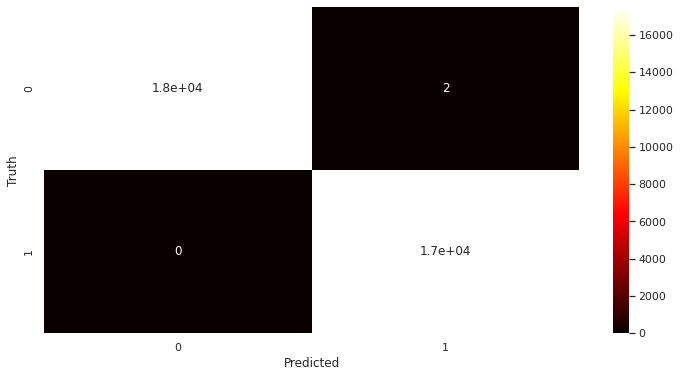

In [ ]:
plt.figure(figsize = (12, 6))

sns.heatmap(cm, annot = True, cmap = "hot")
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [ ]:
accuracy = dt.score(X_test, y_test)
print("DT Accuracy:",accuracy)
print(classification_report(y_test, y_pred))

DT Accuracy: 0.999942795034609
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17502
         1.0       1.00      1.00      1.00     17460

    accuracy                           1.00     34962
   macro avg       1.00      1.00      1.00     34962
weighted avg       1.00      1.00      1.00     34962



**Random Forest Classifier**

In [ ]:
rf = RandomForestClassifier(random_state = 5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[17500,     2],
       [    0, 17460]])

In [ ]:
precision_score(y_test, y_pred)

0.9998854655824075

Text(84.5, 0.5, 'Truth')

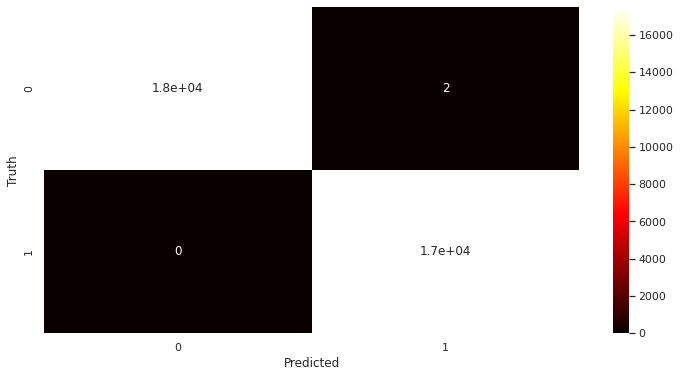

In [ ]:
plt.figure(figsize = (12, 6))

sns.heatmap(cm, annot = True, cmap = "hot")
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [ ]:
accuracy = rf.score(X_test, y_test)
print("RF Accuracy:",accuracy)
print(classification_report(y_test, y_pred))

RF Accuracy: 0.999942795034609
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17502
         1.0       1.00      1.00      1.00     17460

    accuracy                           1.00     34962
   macro avg       1.00      1.00      1.00     34962
weighted avg       1.00      1.00      1.00     34962



**Thank you for viewing this notebook. Please feel free to provide any feedback on this notebook! I am always looking to improve.**